## *Câu hỏi:* ##
# Các đặc điểm về số tập, loại hình và thời lượng tập phim có tạo thành những cụm anime đặc trưng không? #

**Lợi ích:** 
- Xác định các nhóm anime có đặc điểm chung về số tập, loại hình, và thời lượng, qua đó nhận diện các mẫu trong dữ liệu.
- Hỗ trợ xây dựng danh mục anime theo từng nhóm nhằm dễ dàng tổ chức, tìm kiếm khi xây dựng hệ thống
---

# Đọc dữ liệu #

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [51]:
data = pd.read_csv('../data/anime_preprocessing.csv')
print(data.shape)
data.head()

(16917, 15)


,ID,Title,Episodes,Type,Aired,Producers,Studios,Source,Genres,Duration (mins),Score,Scored By,Rank,Popularity,Year
0,1.0,Cowboy Bebop,26.0,TV,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Sunrise,Original,"Action, Award Winning, Sci-Fi",24.0,8.75,988000.0,482.0,43.0,1998.0
1,5.0,Cowboy Bebop: Tengoku no Tobira,1.0,Movie,"Sep 1, 2001","Sunrise, Bandai Visual",Bones,Original,"Action, Sci-Fi",115.0,8.38,219779.0,2092.0,631.0,2001.0
2,6.0,Trigun,26.0,TV,"Apr 1, 1998 to Sep 30, 1998",Victor Entertainment,Madhouse,Manga,"Action, Adventure, Sci-Fi",24.0,8.22,380049.0,3602.0,258.0,1998.0
3,7.0,Witch Hunter Robin,26.0,TV,"Jul 3, 2002 to Dec 25, 2002","Bandai Visual, Dentsu, Victor Entertainment",Sunrise,Original,"Action, Drama, Mystery, Supernatural",25.0,7.24,44600.0,30982.0,1908.0,2002.0
4,8.0,Bouken Ou Beet,52.0,TV,"Sep 30, 2004 to Sep 29, 2005","TV Tokyo, Dentsu",Toei Animation,Manga,"Action, Adventure, Fantasy",23.0,6.93,6891.0,45862.0,5485.0,2004.0


# Tiền xử lý #

### Giảm dữ liệu không cần thiết và xử lý null ###

In [52]:
# Bỏ những thuộc tính không xét đến để giảm dữ liệu khi tính toán
#df = df.drop(columns=['Producers', 'Studios', 'Source', 'Genres', 'Aired', 'Scored By', 'Year'])
df = data[['Episodes', 'Type', 'Duration (mins)', 'Score', 'Popularity']]
df.head()

,Episodes,Type,Duration (mins),Score,Popularity
0,26.0,TV,24.0,8.75,43.0
1,1.0,Movie,115.0,8.38,631.0
2,26.0,TV,24.0,8.22,258.0
3,26.0,TV,25.0,7.24,1908.0
4,52.0,TV,23.0,6.93,5485.0


In [53]:
# Kiểm tra dữ liệu thiếu
df.isnull().sum()

Episodes           76
Type                0
Duration (mins)     0
Score               0
Popularity          0
dtype: int64

In [54]:
# Vì dữ liệu thiếu không quá nhiều so với tập dữ liệu, và để tránh bị bias khi điền dữ liệu thì những dữ liệu null sẽ bị xóa
df = df.dropna()
df.isnull().sum()

Episodes           0
Type               0
Duration (mins)    0
Score              0
Popularity         0
dtype: int64

In [55]:
# Kiểm tra giá trị cột Type xem có loại hình không phù hợp không
df['Type'].unique()

array(['TV', 'Movie', 'OVA', 'TV Special', 'Special', 'ONA', 'Music',
       'CM', 'PV', 'UNKNOWN'], dtype=object)

Vì loại hình 'UNKNOWN' không có giá trị trong phân tích nên nhóm loại bỏ khỏi dữ liệu

In [56]:
df = df[df['Type']!='UNKNOWN']

### Chuẩn hóa ###

In [57]:
# Mã hóa cột Type bằng One-Hot Encoding vì thuật toán không thể làm việc với dữ liệu categorical
df = pd.get_dummies(df, columns=['Type'], drop_first=True)  # drop_first để tránh multicollinearity

In [58]:
# Chuẩn hóa các cột Episodes, Duration (mins), Type về cùng thang đo
# Lấy các cột cần chuẩn hóa
features = ['Episodes', 'Duration (mins)', 'Score'] + [col for col in df.columns if col.startswith('Type_')]
X = df[features]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Phân cụm dữ liệu #

### Chọn số phân cụm k

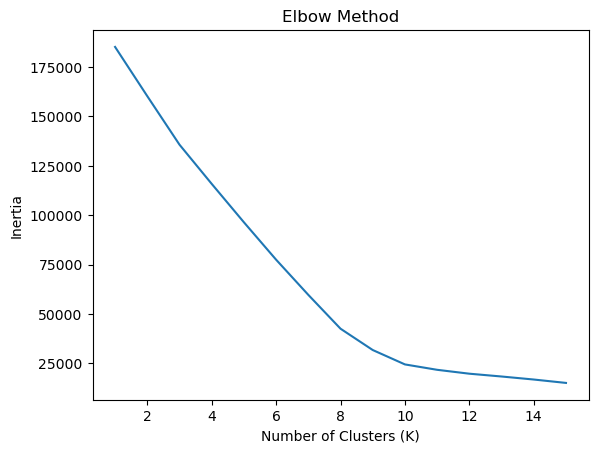

In [69]:
# Elbow method
inertia = []
for k in range(1, 16): # Vì dữ liệu lớn nên đặt giới hạn cụm 1-15
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 16), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

Phương pháp Elbow dựa trên Inertia (hoặc tổng bình phương khoảng cách từ điểm đến tâm cụm). Inertia giảm khi số cụm K tăng, nhưng có 1 điểm mà tại số sự giảm này chậm lại tạo thành góc cùi chỏ.

Dùng khi cần nhìn tổng quan, nhanh chóng. Nhưng khó nhìn ra cùi chỏ với dữ liệu hiện tại.

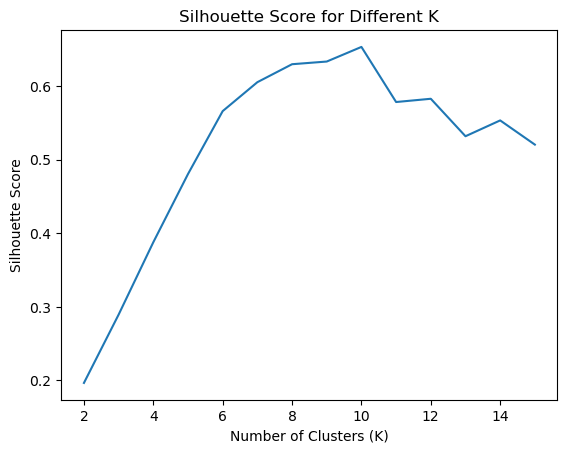

In [70]:
# Silhoutted Score
sil_score = []
for k in range(2, 16):  # Không thể tính silhouette score với 1 cụm
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_score.append(score)

plt.plot(range(2, 16), sil_score)
plt.title('Silhouette Score for Different K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()


Silhouette Score đánh giá chất lượng phân cụm, thể hiện mức độ các điểm trong cùng một cụm gần nhau và mức độ các điểm trong các cụm khác biệt nhau. Điểm dao động từ -1 đến 1:
- 1: Cụm tốt (các điểm gần nhau trong cùng một cụm, xa các cụm khác).
- 0: Các điểm nằm ở ranh giới giữa các cụm.
- -1: Các điểm có thể bị phân cụm sai.

=> Chọn cụm K tại nơi điểm cao => K = 10

Dùng khi muốn chọn số cụm tối ưu và đánh giá mô hình phân cụm

### Thực hiện phân cụm

In [72]:
# Chọn số cụm K đã xác định (ví dụ K = 3)
kmeans = KMeans(n_clusters=10, random_state=42)

# Áp dụng K-Means và thêm nhãn cụm vào DataFrame
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [74]:
clusters = df.groupby('Cluster').mean().reset_index()  # Tính giá trị trung bình của mỗi cụm
clusters

,Cluster,Episodes,Duration (mins),Score,Popularity,Type_Movie,Type_Music,Type_ONA,Type_OVA,Type_PV,Type_Special,Type_TV,Type_TV Special
0,0,1.114660,3.362921,5.930869,16192.424084,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,1,1.181818,1.889848,5.918864,13263.606061,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0
2,2,1.032740,88.965125,7.026463,6775.008541,0.996441,0.0,0.001423,0.002135,0.0,0.0,0.000000,0.0
3,3,27.890122,20.858317,6.843092,5326.530617,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.995093,0.0
4,4,2.461538,28.794097,6.229134,8571.495626,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0
5,5,12.252669,10.180641,6.200483,11064.966955,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.0
6,6,1642.900000,7.800000,6.096000,12168.100000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0
7,7,1.387879,40.305051,6.481838,8937.264646,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0
8,8,1.362483,13.144186,5.627370,13550.369159,0.805741,0.0,0.000000,0.000000,0.0,0.0,0.001335,0.0
9,9,2.848698,12.596552,6.428184,8672.919775,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.0


### Phân tích cụm:

**Các loại hình anime:**
- **ONA (Original Net Animation):** Phát hành trực tuyến trên các nền tảng như YouTube, Netflix.  
- **OVA (Original Video Animation):** Phát hành dưới dạng video trực tiếp (DVD/Blu-ray), thường là tập đặc biệt.  
- **Special:** Ngoại truyện hoặc tập phim ngắn.  
- **TV:** Phát sóng trên truyền hình, gồm các series dài hơi.  
- **TV Special:** Tập phim đặc biệt phát sóng trên truyền hình.  
- **Movie:** Anime dạng phim chiếu rạp với thời lượng dài hơn.  

**Cụm 0:**
- **Episodes:** Trung bình **1.11 tập**, rất ít.  
- **Duration (mins):** **3.36 phút**, cực kỳ ngắn.  
- **Score:** **5.93**, điểm trung bình.  
- **Type:** Chủ yếu là **Music**.  
✅ *Đây là cụm dành cho anime thể loại **Music**, thường rất ngắn và có điểm trung bình thấp.*  

**Cụm 1:**
- **Episodes:** Trung bình **1.18 tập**, rất ít.  
- **Duration (mins):** **1.89 phút**, cực kỳ ngắn.  
- **Score:** **5.92**, điểm trung bình.  
- **Type:** Chủ yếu là **PV (Promotional Video)**.  
✅ *Cụm này dành cho **PV** - các video quảng cáo ngắn hoặc giới thiệu anime.*  

**Cụm 2:**
- **Episodes:** Trung bình **1.03 tập**, gần như chỉ có 1 tập.  
- **Duration (mins):** **88.97 phút**, rất dài.  
- **Score:** **7.03**, cao nhất trong các cụm.  
- **Type:** Chủ yếu là **Movie**.  
✅ *Đây là cụm dành riêng cho các anime dạng **Movie**, có thời lượng dài và chất lượng cao.*  

**Cụm 3:**
- **Episodes:** Trung bình **27.89 tập**, cao.  
- **Duration (mins):** **20.86 phút**, phù hợp cho anime TV series.  
- **Score:** **6.84**, cao.  
- **Type:** Chủ yếu là **TV**.  
✅ *Đây là cụm dành cho các anime **TV series** dài tập với chất lượng ổn định.*  

**Cụm 4:**
- **Episodes:** Trung bình **2.46 tập**, rất ngắn.  
- **Duration (mins):** **28.79 phút**, tương đối dài.  
- **Score:** **6.23**, trung bình.  
- **Type:** Chủ yếu là **OVA**.  
✅ *Cụm này đại diện cho anime **OVA**, các tập đặc biệt phát hành dưới dạng video.*  

 **Cụm 5:**
- **Episodes:** Trung bình **12.25 tập**, trung bình.  
- **Duration (mins):** **10.18 phút**, thời lượng ngắn.  
- **Score:** **6.20**, trung bình.  
- **Type:** Chủ yếu là **ONA**.  
✅ *Đây là cụm dành cho anime **ONA**, thường phát hành trực tuyến và có thời lượng ngắn.*  

**Cụm 6:**
- **Episodes:** Trung bình **1642.9 tập**, cực kỳ cao.  
- **Duration (mins):** **7.8 phút**, rất ngắn.  
- **Score:** **6.09**, thấp hơn mức trung bình.  
- **Type:** Chủ yếu là **TV**.  
✅ *Cụm này đại diện cho các anime **TV series** dài hơi với số tập cực lớn.*  

**Cụm 7:**
- **Episodes:** Trung bình **1.39 tập**, rất ít.  
- **Duration (mins):** **40.31 phút**, thời lượng dài.  
- **Score:** **6.48**, khá cao.  
- **Type:** Chủ yếu là **TV Special**.  
✅ *Cụm này tập trung các anime **TV Special** - tập phim đặc biệt của TV series.*  

**Cụm 8:**
- **Episodes:** Trung bình **1.36 tập**, rất ít.  
- **Duration (mins):** **13.14 phút**, ngắn.  
- **Score:** **5.63**, thấp nhất trong các cụm.  
- **Type:** Chủ yếu là **Movie** và một số ít thuộc **TV**.  
⚠️ *Đây là cụm đại diện cho các anime ngắn tập có điểm số thấp.*  

**Đề xuất sử dụng cụm**:
- **Cụm 2 và cụm 3:** Chất lượng cao, phù hợp để ưu tiên nếu người xem chú trọng **anime Movie** hoặc **TV series**.  
- **Cụm 4 và cụm 7:** Phù hợp cho các tập **OVA** hoặc **TV Special**.  
- **Cụm 5:** Thích hợp với người xem tìm kiếm anime ngắn phát hành trực tuyến (**ONA**).  
- **Cụm 6:** Dành cho người yêu thích các anime **TV series dài tập**.  
- **Cụm 0 và cụm 1:** Các anime ngắn hoặc video quảng cáo như **Music** và **PV**.  
- **Cụm 8:** Nên tránh do điểm số thấp và ít thông tin.  

# Mở rộng #

### 1. Vì sao những cụm anime có Số tập, Thời lượng, Loại hình đạt được điểm số như vậy?
**Cụm 0 (Anime Music):**
- Đây là cụm dành cho anime thể loại Music, thường có số tập và thời gian ngắn. Vì là thể loại dành riêng cho âm nhạc, anime dạng này thường không có nhiều chiều sâu về nội dung, và điểm số vì thế cũng không cao.

**Cụm 1 (Anime PV - Promotional Video):**
- Cụm này chủ yếu là các video quảng cáo ngắn hoặc giới thiệu về anime. Vì chỉ là video quảng bá, nội dung ít được phát triển, dẫn đến điểm số trung bình thấp.

**Cụm 2 (Anime Movie):**
- Đây là cụm dành riêng cho các anime dạng Movie. Anime Movie có thời lượng dài và chất lượng hình ảnh, âm thanh tốt hơn nhờ nguồn lực đầu tư cao. Điều này giúp chúng đạt điểm số cao, vì tính chất đặc biệt và sự đầu tư vào chất lượng.

**Cụm 3 (Anime TV Series):**
- Cụm này chủ yếu là các anime TV series dài tập với chất lượng ổn định. Các series TV thường có nội dung đa dạng, được đầu tư đều đặn, giữ được sự quan tâm của người xem qua nhiều tập.

**Cụm 4 (OVA - Original Video Animation):**
- Cụm này đại diện cho anime OVA, thường là các tập phim đặc biệt phát hành trực tiếp trên video. Mặc dù có thời gian dài hơn so với các anime khác, nhưng điểm số trung bình vì chất lượng sản xuất không đồng đều và không phải tất cả đều được đầu tư như anime TV series.

**Cụm 5 (ONA - Original Net Animation):**
- Cụm này đại diện cho anime ONA, thường phát hành trực tuyến và có thời lượng ngắn. Anime ONA không được đầu tư mạnh như TV series, nhưng lại thu hút khán giả trẻ nhờ sự tiện lợi và phát hành trực tuyến.

**Cụm 6 (TV Series Dài Tập):**
- Cụm này đại diện cho các anime TV series dài tập, thường được phát sóng liên tục qua nhiều năm. Số tập cực kỳ lớn, nhưng thời gian mỗi tập ngắn, do đó có thể bị ảnh hưởng đến chất lượng và tính hấp dẫn, dẫn đến điểm số thấp hơn.

**Cụm 7 (TV Special):**
- Cụm này bao gồm các tập đặc biệt của anime TV, thường có nội dung bổ sung hoặc ngoại truyện. Mặc dù điểm số khá cao, nhưng các tập này thường không phát triển quá nhiều về nội dung chính.

**Cụm 8 (Anime Ngắn, Movie và TV):**
- Đây là cụm đại diện cho các anime ngắn tập, với điểm số thấp và ít thông tin. Thường là những sản phẩm thử nghiệm hoặc có ít đầu tư, chất lượng không ổn định.

### 2. Vì sao điểm của các cụm lại có sự khác biệt? ###
**1. Chất lượng sản xuất và đầu tư**
- Anime Movie (Cụm 2) có thời gian dài và thường được đầu tư mạnh vào chất lượng hình ảnh, âm thanh, và nội dung. Do đó, những anime này có điểm số cao hơn. Các phim này cũng có thể dựa trên các nguyên tác nổi tiếng hoặc được tạo ra với đội ngũ sáng tạo hàng đầu, giúp nâng cao chất lượng sản phẩm.
OVA (Cụm 4) và TV Special (Cụm 7) thường được phát hành dưới dạng các tập phim đặc biệt, nhưng không phải lúc nào cũng được đầu tư như các series chính. Điều này khiến điểm số của chúng dao động từ trung bình đến cao, nhưng ít khi đạt mức điểm cao như các anime Movie.

**2. Mục đích phát hành**
- PV (Cụm 1) và Music (Cụm 0) là các anime có mục đích quảng bá hoặc giới thiệu, không phải là các tác phẩm nghệ thuật được đầu tư vào nội dung sâu sắc. Chúng thường có thời lượng rất ngắn và thiếu chiều sâu, dẫn đến điểm số thấp. Những anime này chỉ mang tính chất hỗ trợ chiến dịch quảng bá sản phẩm hoặc nghệ sĩ, nên chất lượng nội dung và điểm số thường không cao.
ONA (Cụm 5) là anime phát hành trực tuyến, với thời gian ngắn và thường thiếu sự đầu tư mạnh mẽ như các anime TV hoặc Movie. Điều này cũng khiến điểm số của chúng không cao, mặc dù chúng có thể thu hút một lượng khán giả nhất định nhờ tính tiện dụng và dễ tiếp cận.

**3. Loại hình và số lượng tập**
- TV Series (Cụm 3) có số lượng tập lớn và có thời gian phát sóng dài, giúp xây dựng một cộng đồng người hâm mộ ổn định và phát triển nội dung một cách sâu sắc qua nhiều tập. Mặc dù không phải lúc nào các anime TV series cũng có chất lượng tương đương, nhưng điểm số trung bình vẫn ổn định nhờ vào sự phát triển dần dần của cốt truyện và sự đầu tư ổn định.
- TV series dài tập (Cụm 6) có số tập cực kỳ lớn, nhưng thời gian mỗi tập lại ngắn. Điều này đôi khi ảnh hưởng đến chất lượng của nội dung và cách phát triển các mối quan hệ trong anime, dẫn đến điểm số thấp hơn so với các anime TV series ngắn tập. Một số anime dài tập có thể gây cảm giác lặp lại, thiếu sáng tạo và giảm sự hấp dẫn cho người xem.

**4. Thời gian phát hành và số lượng người xem**
- Movie (Cụm 2) có thời gian chiếu dài và thường được phát hành vào các dịp đặc biệt, thu hút sự chú ý của nhiều khán giả. Vì thế, chúng thường nhận được nhiều phản hồi tích cực hơn, đặc biệt là khi có sự tham gia của những tên tuổi nổi tiếng trong ngành. Ngược lại, các anime như Cụm 0 và Cụm 1 chỉ có mục đích quảng cáo và thời gian phát hành rất ngắn, làm giảm khả năng thu hút và tạo ấn tượng với người xem.

**5. Đối tượng khán giả**
- Anime TV Series (Cụm 3) và Movie (Cụm 2) thường nhắm đến đối tượng khán giả rộng rãi, bao gồm cả những người yêu thích những câu chuyện dài hơi và những người yêu thích các bộ phim điện ảnh. Do đó, chúng có xu hướng được đánh giá cao hơn.
Các thể loại như Music và PV thường nhắm đến đối tượng hẹp hơn, chủ yếu là fan của nghệ sĩ hoặc các chiến dịch quảng bá, khiến chất lượng nội dung bị hạn chế và điểm số thấp hơn.

**6. Độ dài tập phim và sự phát triển của cốt truyện**
- Các anime có thời gian dài (Cụm 2 và Cụm 3) có thể phát triển cốt truyện tốt hơn và tạo ra sự gắn kết với người xem, dẫn đến điểm số cao. Trong khi đó, các anime ngắn hoặc có thời gian ngắn như Cụm 1 và Cụm 0 không đủ thời gian để phát triển cốt truyện, khiến người xem dễ dàng cảm thấy thiếu thốn về nội dung và dẫn đến đánh giá thấp.


# Kết luận #
- Hoàn toàn có thể dùng những yếu tố như Loại hình, Số tập, Thời lượng để phân cụm anime khi xây dựng hệ thống đề xuất cho người dùng. Trong đó, Số tập và Thời lượng có sự phụ thuộc vào Loại hình anime (TV, Movie, OVA, Special).
- Điểm số thường cao ở các loại hình có đầu tư lớn (TV series, Movie), trung bình ở nội dung bổ sung (OVA, Special) và thấp ở các dạng không phổ biến và chất lượng